In [1]:
import os

import torch
from torch.utils.data import Dataset
import cv2


class SouthParkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.paths = []
        for dir, subdir, files in os.walk(self.root_dir):
            for file in files:
                self.paths.append(os.path.join(dir, file))

    @staticmethod
    def __read_img(path) -> torch.Tensor:
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        return image
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = self.__read_img(self.paths[idx])

        if self.transform:
            image = self.transform(image)

        return image

In [2]:
dataset = SouthParkDataset(root_dir="../single_character_data", transform=None)
len(dataset)

906

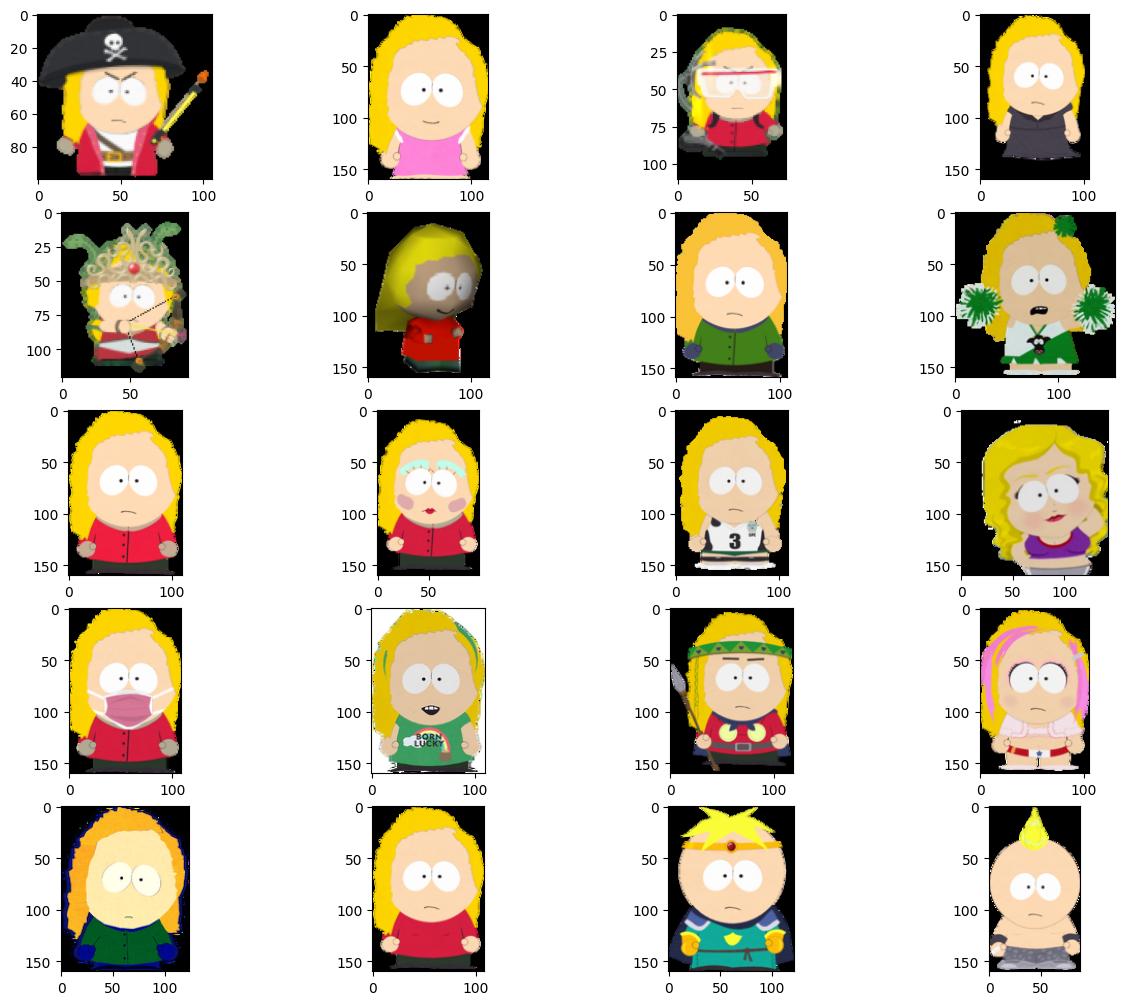

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt


def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)



show_images(dataset)

In [4]:
import torch.nn.functional as F

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 16


def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ])

    dataset = SouthParkDataset(root_dir="../single_character_data", transform=data_transforms)
    
    return dataset


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0]
        
    plt.imshow(reverse_transforms(image))

    
train_dataset = load_transformed_dataset()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


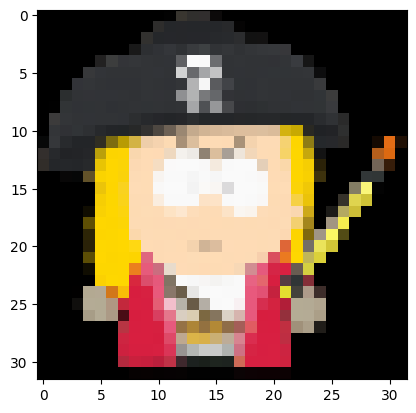

In [6]:
show_tensor_image(train_dataset[0])

In [7]:
!git clone https://github.com/openai/improved-diffusion
!mv improved-diffusion/improved_diffusion ./

fatal: destination path 'improved-diffusion' already exists and is not an empty directory.
mv: cannot stat 'improved-diffusion/improved_diffusion': No such file or directory


In [8]:
! pip install -e improved-diffusion

Obtaining file:///home/leffff/PycharmProjects/south-park-character-generation/models/improved-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: improved-diffusion
    Found existing installation: improved-diffusion 0.0.0
    Uninstalling improved-diffusion-0.0.0:
      Successfully uninstalled improved-diffusion-0.0.0
  Running setup.py develop for improved-diffusion

[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [9]:
from improved_diffusion.unet import UNetModel

model = UNetModel(
    in_channels=3, 
    model_channels=64, 
    out_channels=3,
    num_res_blocks=3, 
    attention_resolutions=("16",)
)
model

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-3): 3 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection

# Ну вот вроде как наш лосс 

<img src="https://latex.codecogs.com/gif.latex?x_t = t * x_1 + (1 - t) * x_0" /> 
</br>
Лосс
<img src="https://latex.codecogs.com/gif.latex?||f_{\theta }(x_t, t) - (x_1 - x_0)|| ^ 2" /> 

In [10]:
def get_loss(model, x_0, x_1, t):
    t = t.unsqueeze(1).unsqueeze(1).unsqueeze(1)
    x_t = t * x_1 + (1 - t) * x_0
    t = t.flatten()
    noise_pred = model(x_t, t)
    
    return F.mse_loss(noise_pred, (x_1 - x_0), reduction="sum")

In [11]:
def euler_integration(net, x0):
    model.eval()
    
    eps = 1e-8
    n_steps = 100
    t = torch.linspace(eps, 1 - eps, n_steps + 1).to(x0.device)

    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(n_steps / num_images)

    for i in range(1, len(t)):
        with torch.no_grad():
            t_prev = t[i - 1].unsqueeze(0)
#             print(x0.shape, t_prev.shape)
            f_eval = net(x0, t_prev)
        x = x0 + (t[i] - t[i - 1]) * f_eval
        x0 = x
        
        if i % stepsize == 0 or i == (len(t) - 1):
            plt.subplot(1, num_images, int(i / stepsize))
            show_tensor_image(x.detach().cpu())
    plt.show()
    return x

In [12]:
def train_epoch(model, dataloader, device):
    model.to(device)
    model.train()

    total_loss = 0.0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        t = torch.tensor(np.random.uniform(size=(BATCH_SIZE)), dtype=torch.float32).to(device)

        x_1 = batch.to(device)
        x_0 = torch.tensor(np.random.normal(size=list(x_1.size())), dtype=torch.float32).to(device)
        
        loss = get_loss(model, x_0, x_1, t)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader.dataset)

/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                                                                                                                                               | 0/56 [00:00<?, ?it/s]/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current defa

Epoch 0 | Train Loss: 3877.8533474751657


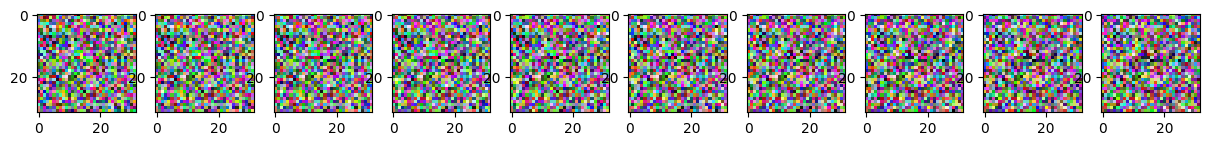

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.24it/s]


Epoch 1 | Train Loss: 2973.171668046358


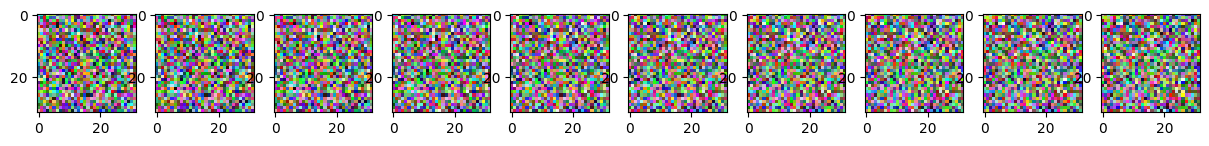

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.86it/s]


Epoch 2 | Train Loss: 2237.3693691363133


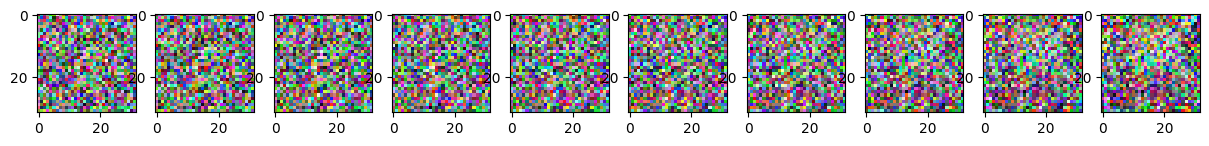

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.87it/s]


Epoch 3 | Train Loss: 1816.382012710403


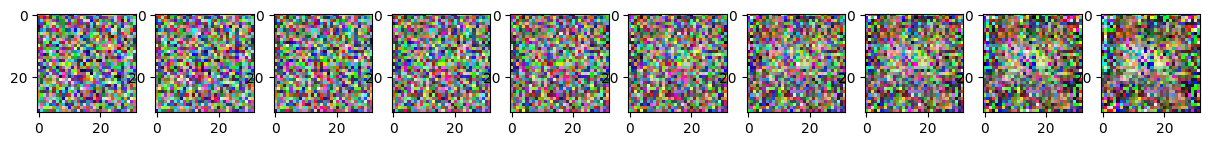

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.11it/s]


Epoch 4 | Train Loss: 1557.4002375655352


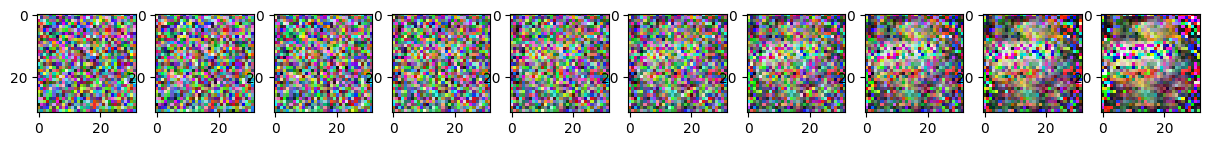

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.42it/s]


Epoch 5 | Train Loss: 1403.456669081126


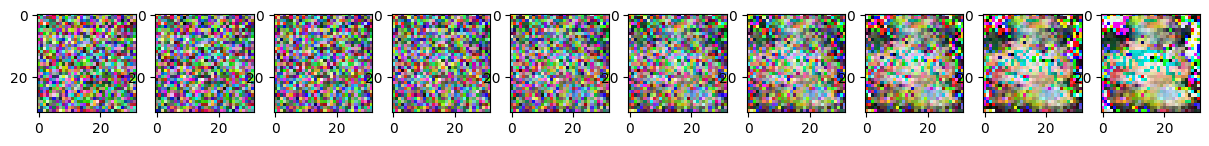

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.41it/s]


Epoch 6 | Train Loss: 1325.9952982719371


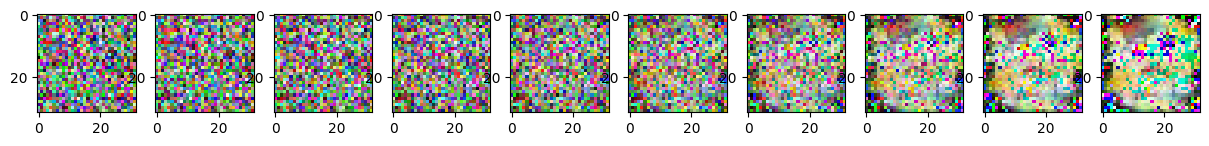

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.96it/s]


Epoch 7 | Train Loss: 1249.780553687224


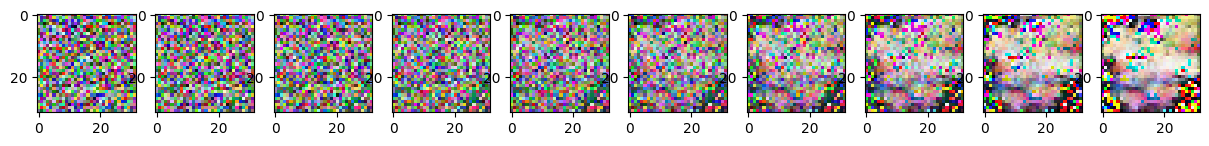

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.26it/s]


Epoch 8 | Train Loss: 1218.2103726890177


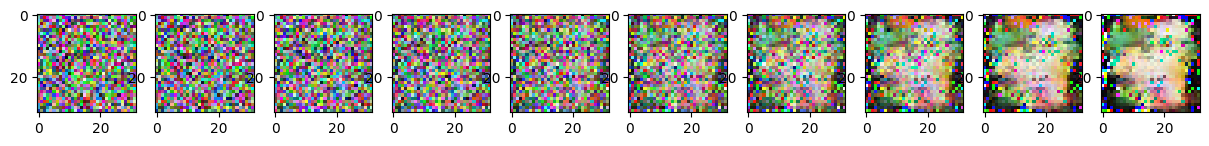

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.42it/s]


Epoch 9 | Train Loss: 1170.9806271988825


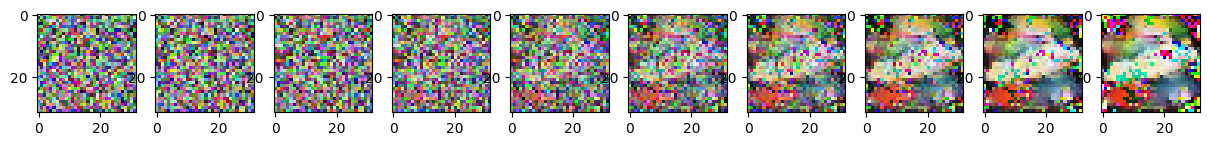

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.11it/s]


Epoch 10 | Train Loss: 1143.6270867825608


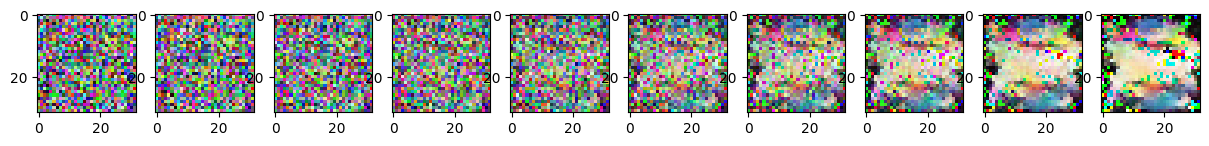

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.04it/s]


Epoch 11 | Train Loss: 1141.3057729287389


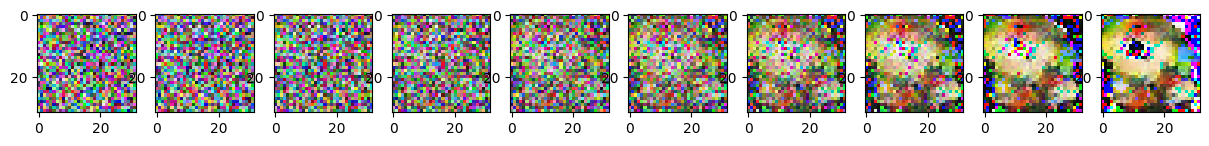

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 18.85it/s]


Epoch 12 | Train Loss: 1115.8563084212885


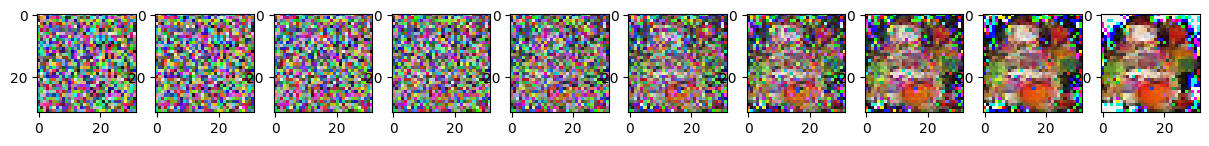

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.49it/s]


Epoch 13 | Train Loss: 1114.2809686723924


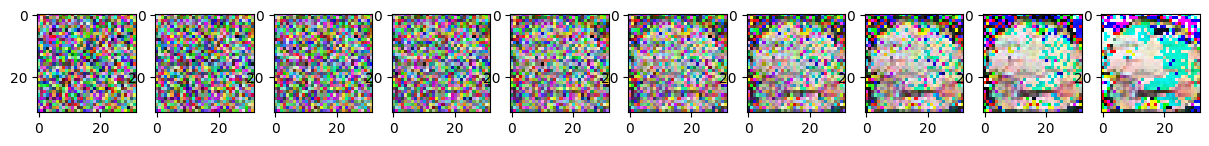

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 18.82it/s]


Epoch 14 | Train Loss: 1090.5393729304635


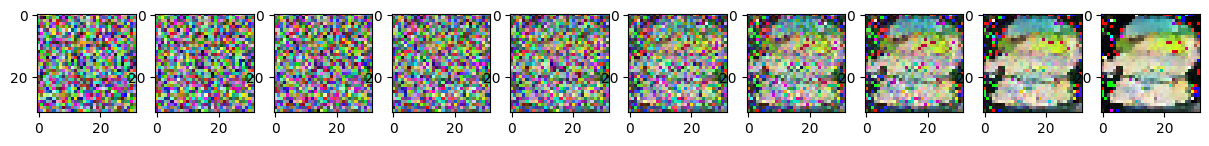

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.55it/s]


Epoch 15 | Train Loss: 1071.0338261416944


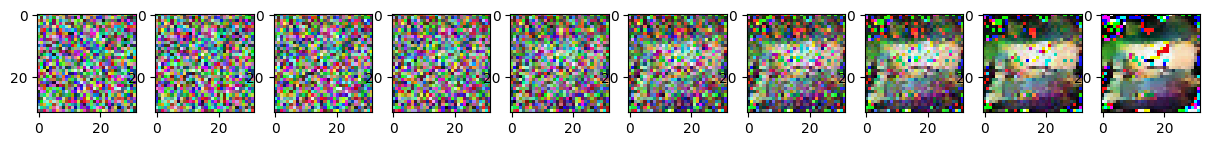

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.67it/s]


Epoch 16 | Train Loss: 1095.0371352442053


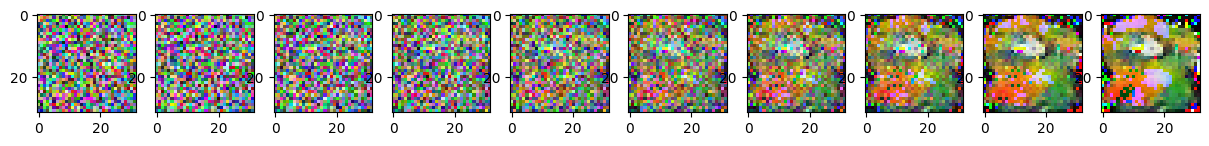

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.67it/s]


Epoch 17 | Train Loss: 1051.5901272333747


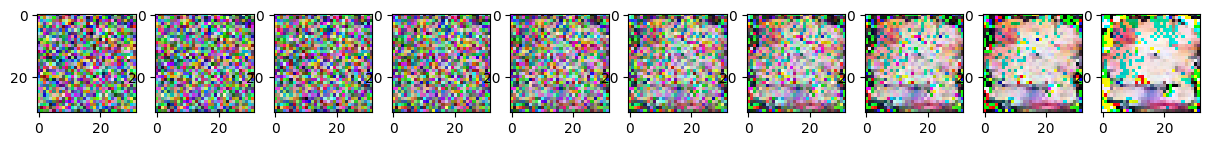

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.75it/s]


Epoch 18 | Train Loss: 1048.0138766728753


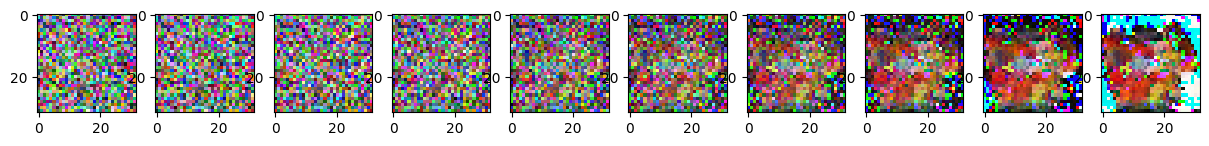

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.23it/s]


Epoch 19 | Train Loss: 1042.0983676531457


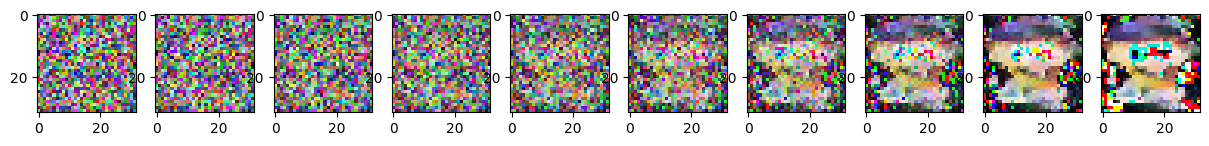

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.99it/s]


Epoch 20 | Train Loss: 1036.047723294357


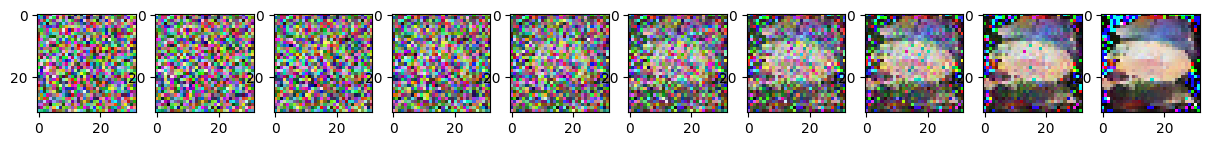

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.16it/s]


Epoch 21 | Train Loss: 997.8602038924531


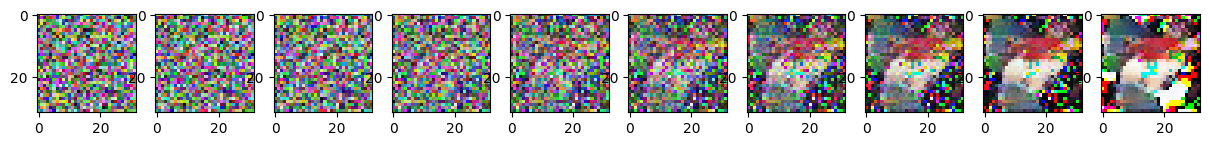

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.76it/s]


Epoch 22 | Train Loss: 996.733139745447


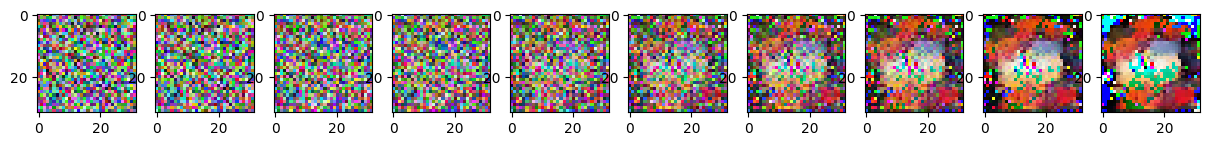

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 14.84it/s]


Epoch 23 | Train Loss: 988.4886531198262


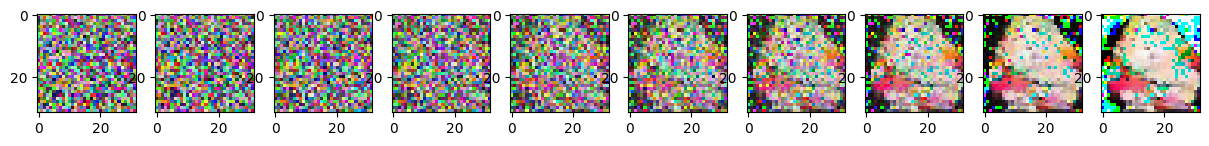

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.47it/s]


Epoch 24 | Train Loss: 1002.3487362893212


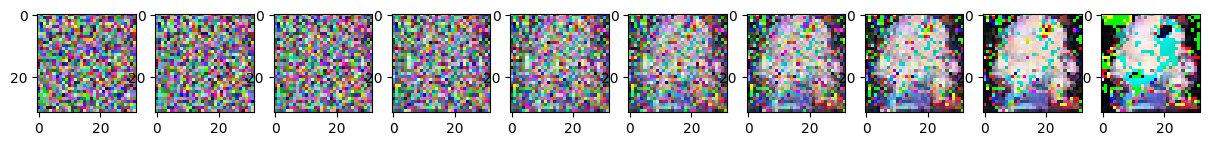

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.87it/s]


Epoch 25 | Train Loss: 956.5638764572985


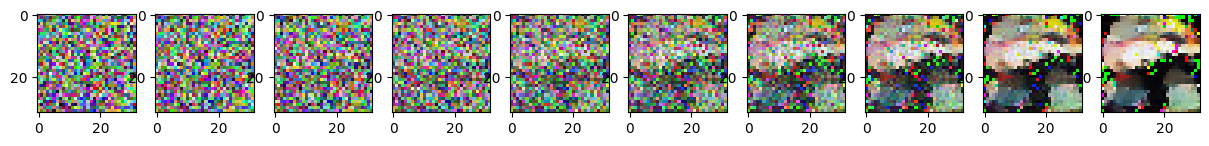

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.24it/s]


Epoch 26 | Train Loss: 974.2891239393626


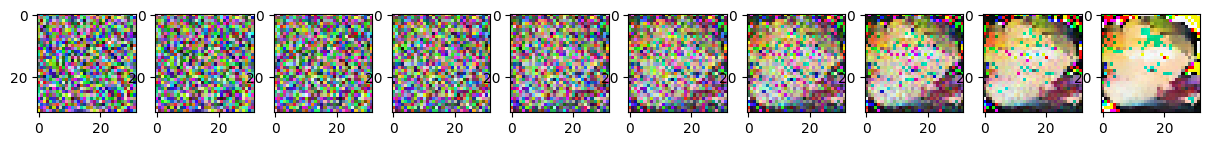

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.64it/s]


Epoch 27 | Train Loss: 984.838898446123


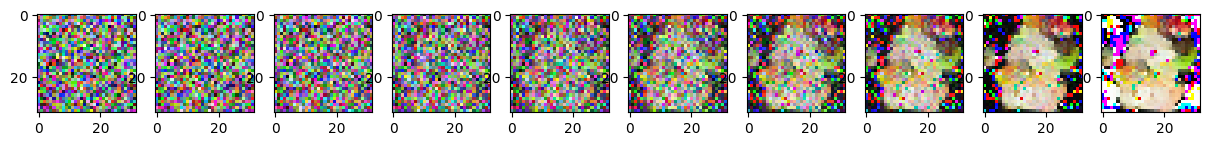

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.09it/s]


Epoch 28 | Train Loss: 945.2401104183913


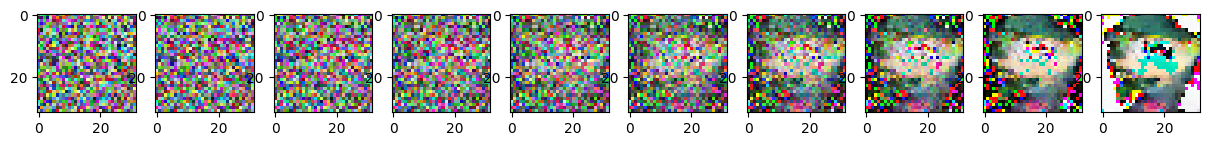

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.66it/s]


Epoch 29 | Train Loss: 940.4842995481512


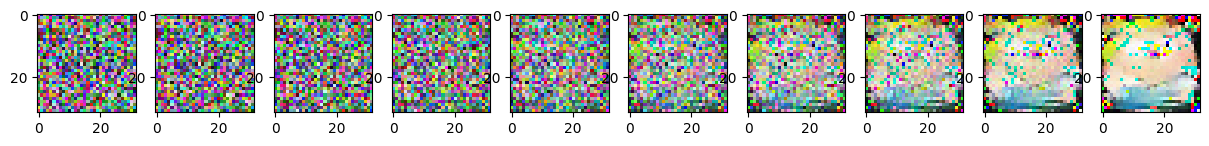

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.52it/s]


Epoch 30 | Train Loss: 946.872848544426


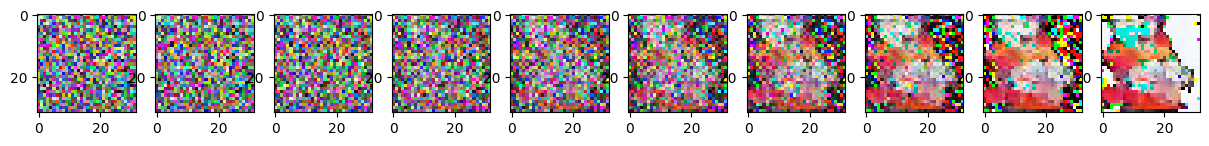

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.46it/s]


Epoch 31 | Train Loss: 933.1956110737444


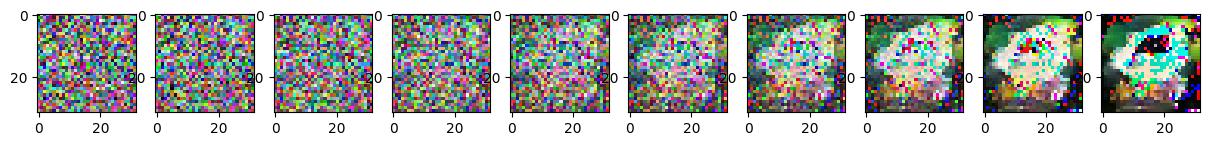

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.48it/s]


Epoch 32 | Train Loss: 922.3992319001794


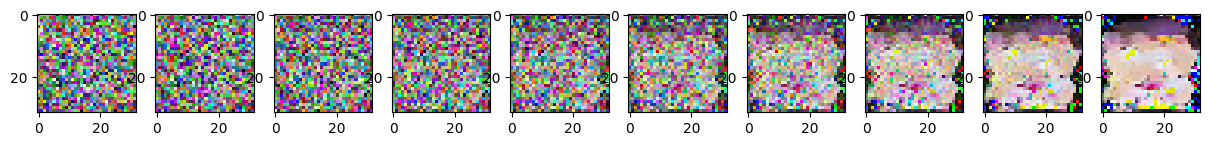

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.29it/s]


Epoch 33 | Train Loss: 927.7585939655767


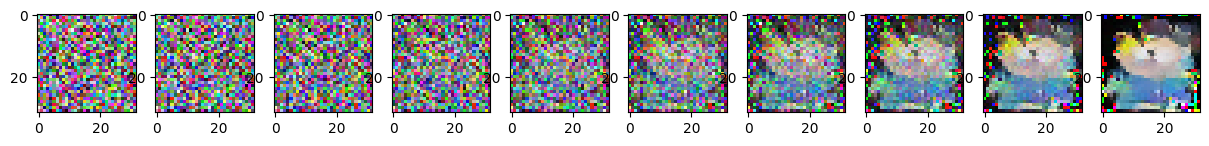

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.37it/s]


Epoch 34 | Train Loss: 922.0006521195502


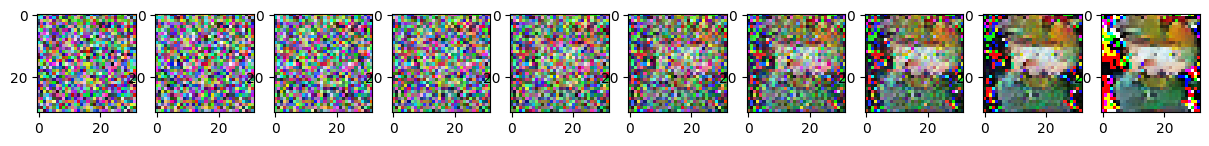

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.47it/s]


Epoch 35 | Train Loss: 905.263732236479


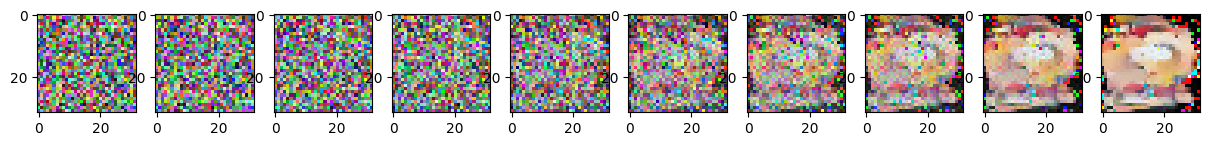

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.40it/s]


Epoch 36 | Train Loss: 912.0434926014073


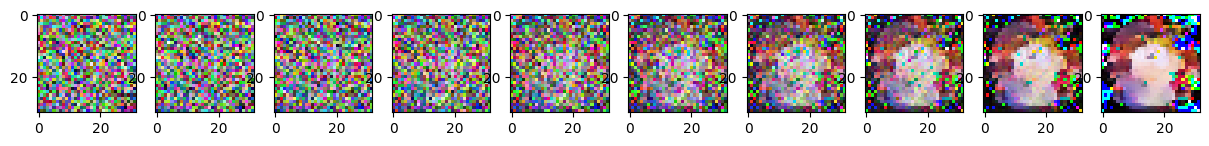

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.24it/s]


Epoch 37 | Train Loss: 941.9856339679911


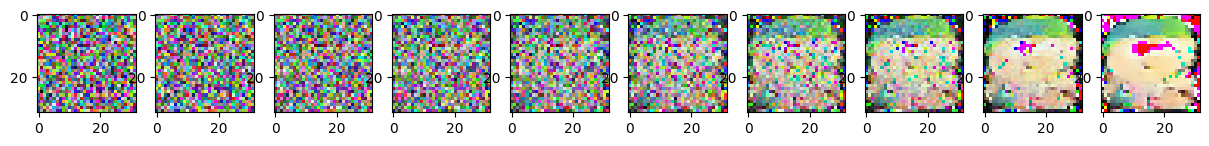

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.40it/s]


Epoch 38 | Train Loss: 938.9951721595612


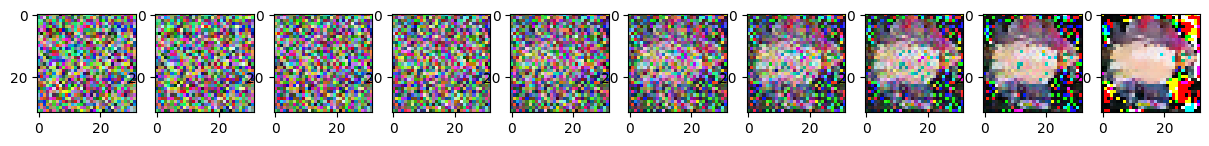

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.55it/s]


Epoch 39 | Train Loss: 897.736536156526


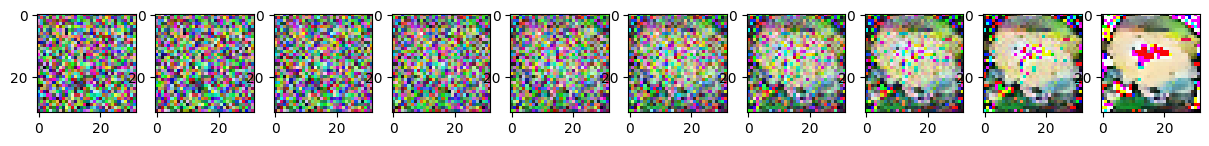

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.36it/s]


Epoch 40 | Train Loss: 894.6602802066087


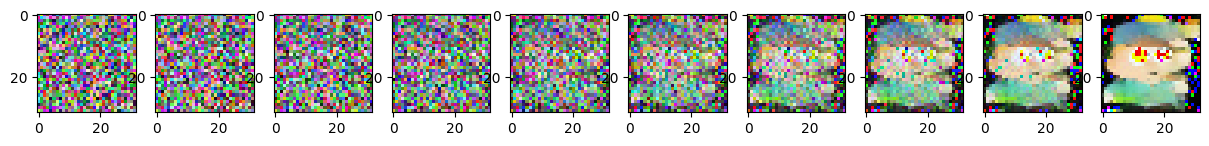

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.39it/s]


Epoch 41 | Train Loss: 888.3112518108444


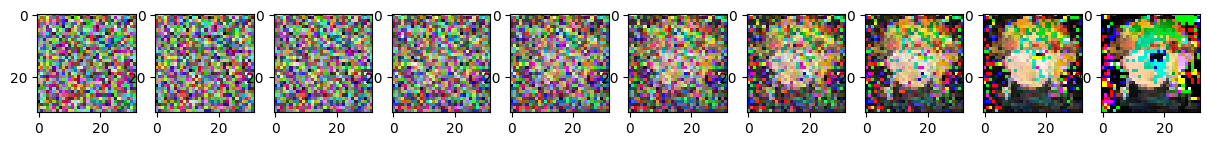

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.39it/s]


Epoch 42 | Train Loss: 886.8218678859686


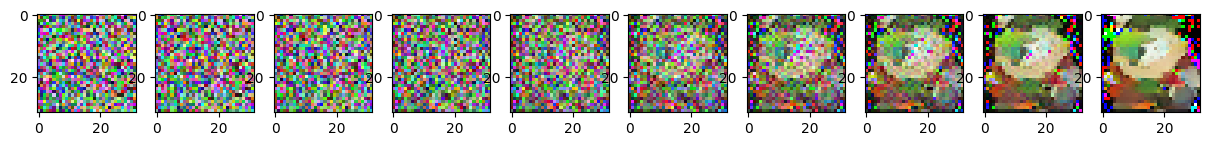

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.16it/s]


Epoch 43 | Train Loss: 896.6684591870171


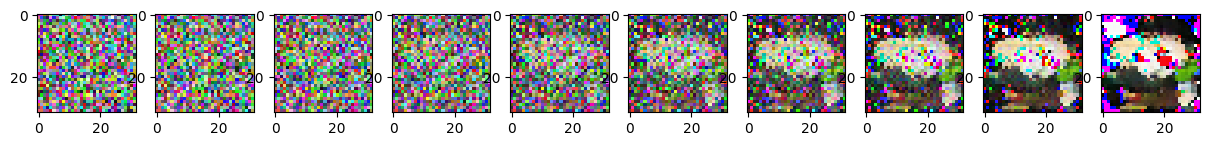

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.82it/s]


Epoch 44 | Train Loss: 888.4619205298013


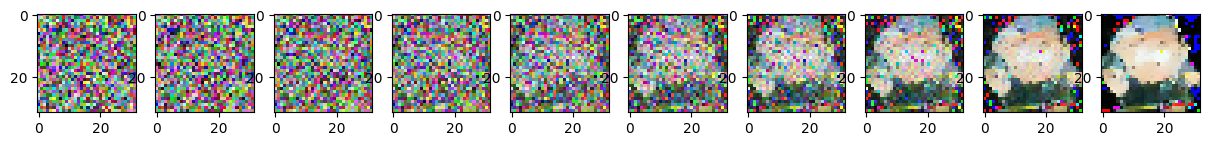

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.56it/s]


Epoch 45 | Train Loss: 859.1831755311811


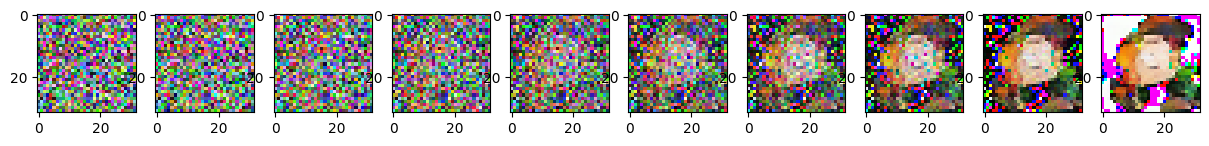

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 14.49it/s]


Epoch 46 | Train Loss: 903.9524804256347


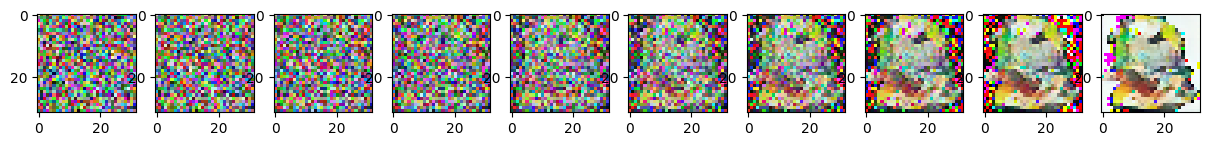

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.46it/s]


Epoch 47 | Train Loss: 872.6061672185431


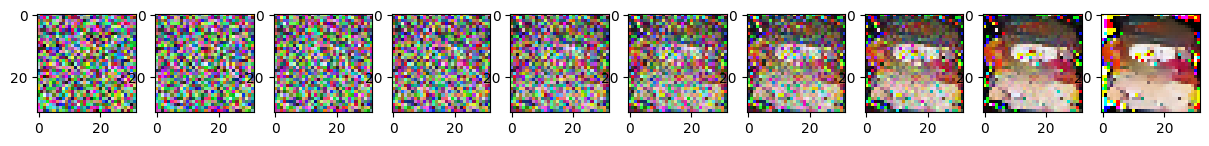

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.50it/s]


Epoch 48 | Train Loss: 885.6349596440398


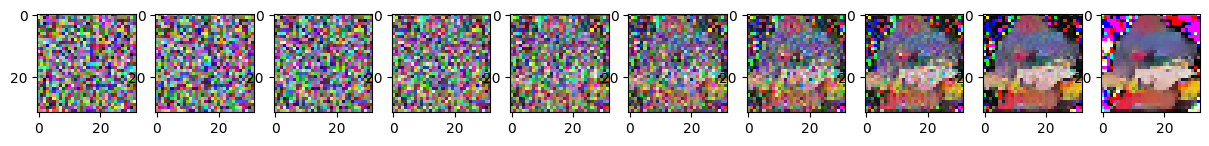

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.22it/s]


Epoch 49 | Train Loss: 853.6665200745033


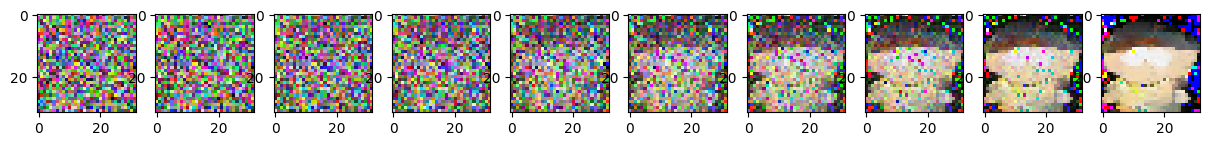

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.62it/s]


Epoch 50 | Train Loss: 876.028649066984


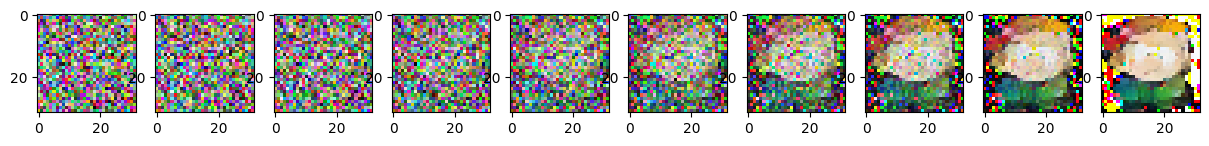

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.87it/s]


Epoch 51 | Train Loss: 846.1375950693294


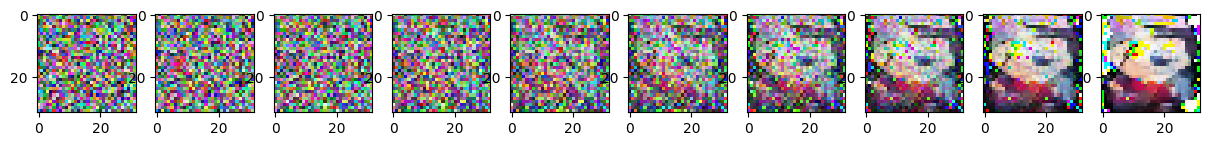

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.39it/s]


Epoch 52 | Train Loss: 867.8243211489377


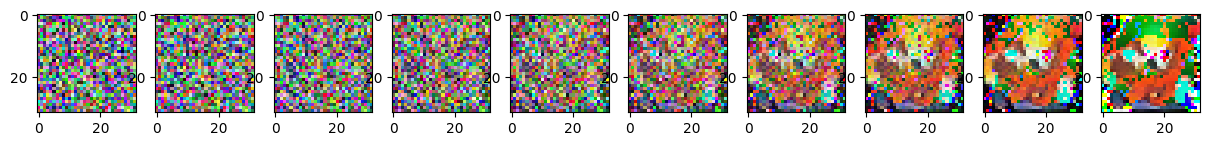

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.40it/s]


Epoch 53 | Train Loss: 872.1663282112307


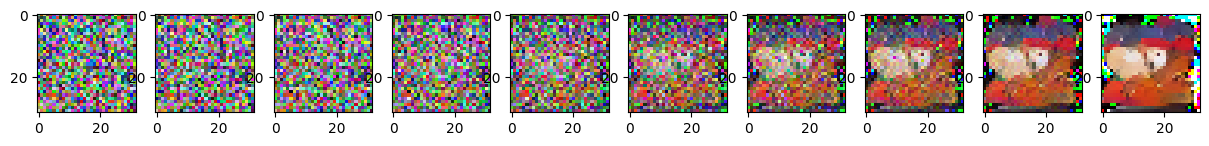

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.53it/s]


Epoch 54 | Train Loss: 868.000338455436


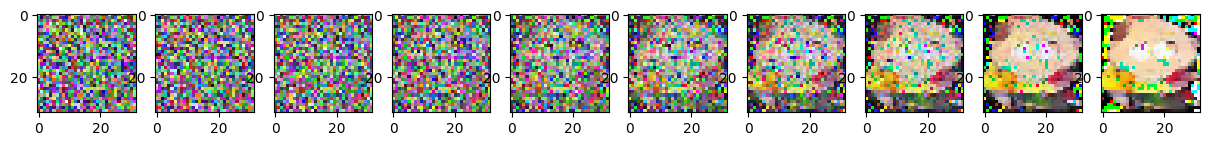

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.98it/s]


Epoch 55 | Train Loss: 850.6327898644454


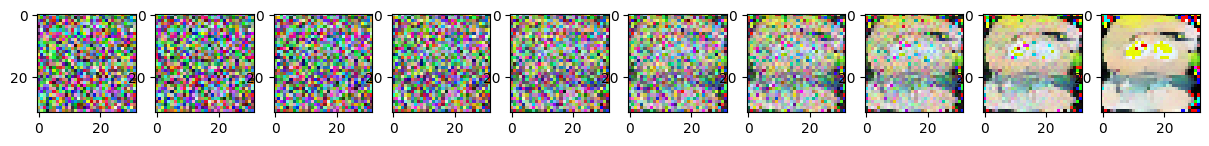

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.05it/s]


Epoch 56 | Train Loss: 860.656317906664


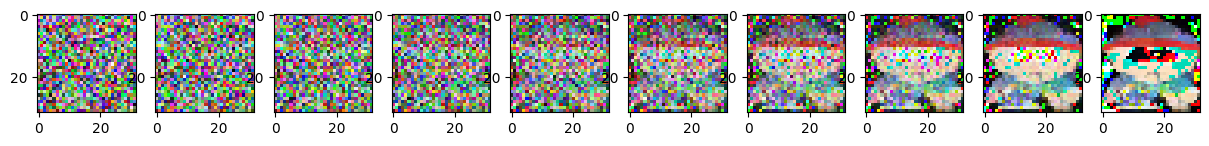

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.78it/s]


Epoch 57 | Train Loss: 850.0946414096992


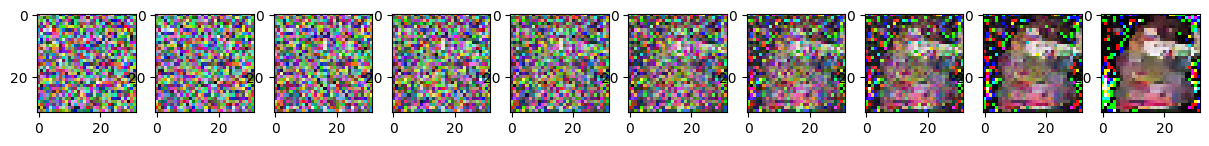

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.77it/s]


Epoch 58 | Train Loss: 857.5559044305326


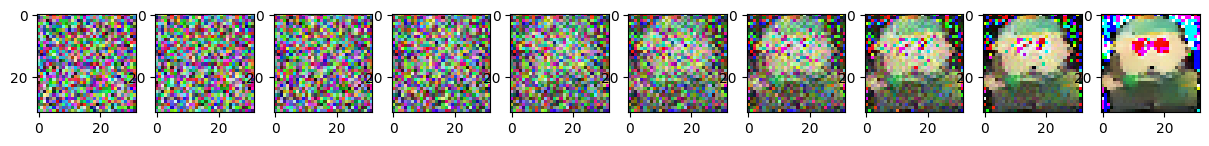

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.64it/s]


Epoch 59 | Train Loss: 846.8511863186396


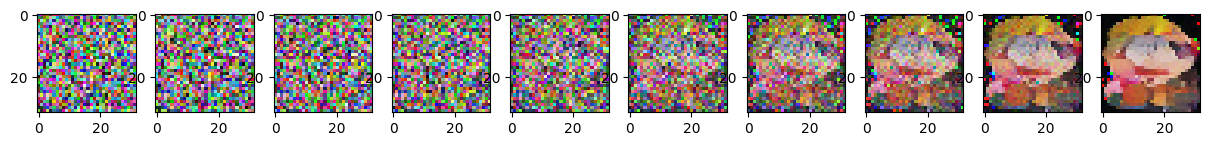

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.98it/s]


Epoch 60 | Train Loss: 842.8812042977373


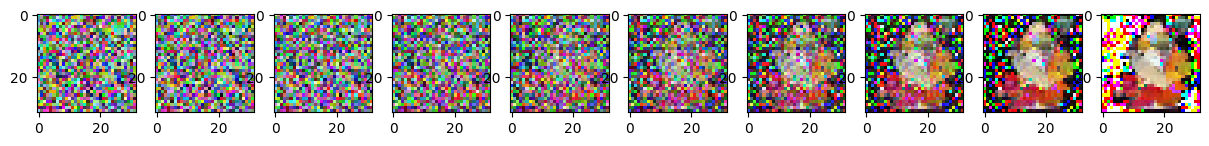

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.69it/s]


Epoch 61 | Train Loss: 817.0087416356237


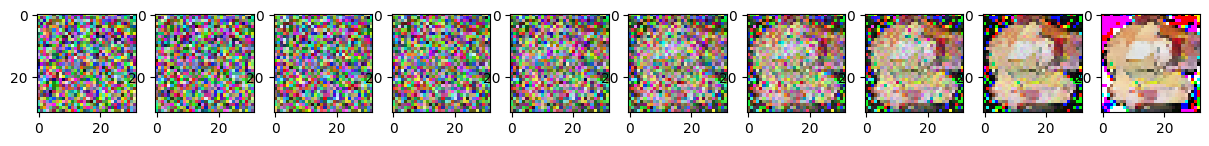

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.58it/s]


Epoch 62 | Train Loss: 830.1987369360513


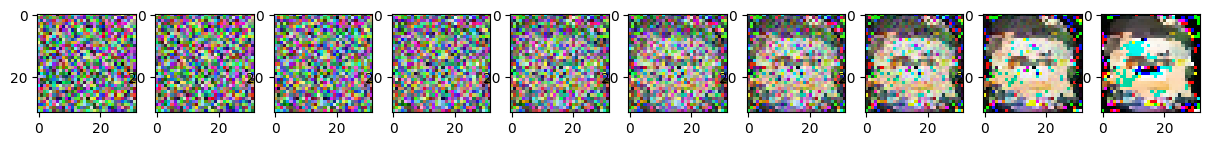

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 14.58it/s]


Epoch 63 | Train Loss: 849.5561372533803


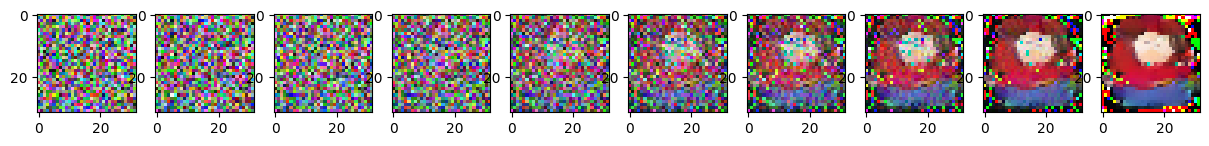

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.08it/s]


Epoch 64 | Train Loss: 814.6221856460403


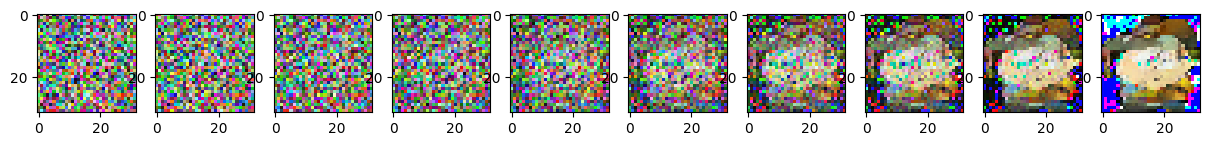

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.60it/s]


Epoch 65 | Train Loss: 826.130221267936


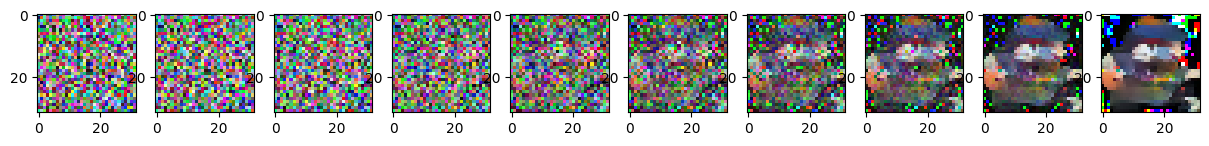

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 14.97it/s]


Epoch 66 | Train Loss: 839.7578890297324


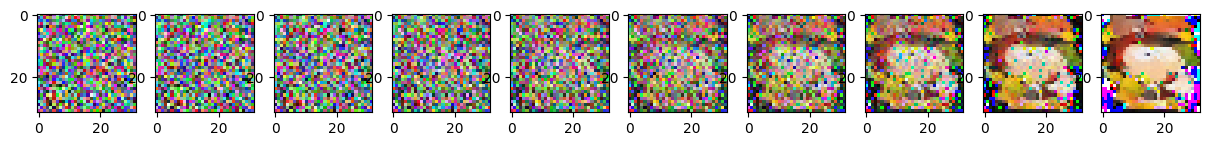

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.05it/s]


Epoch 67 | Train Loss: 825.1192031422462


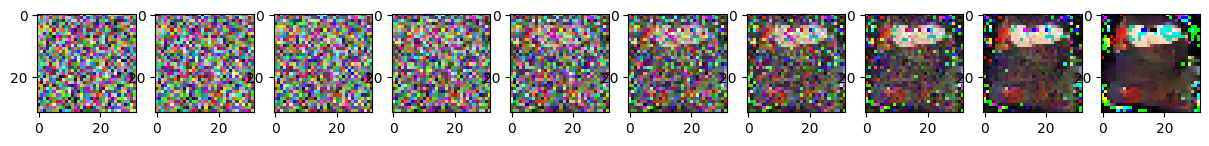

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.26it/s]


Epoch 68 | Train Loss: 838.2775043546495


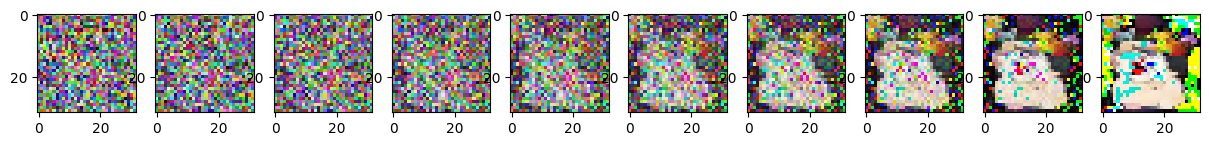

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.36it/s]


Epoch 69 | Train Loss: 820.7533619188052


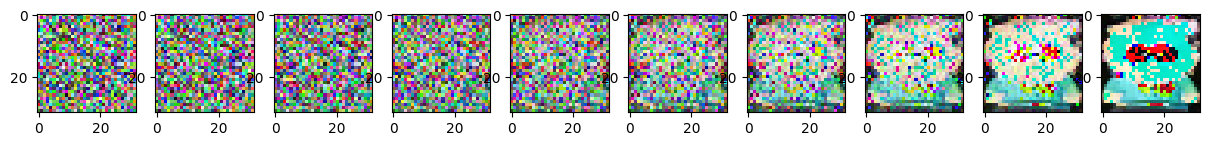

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.85it/s]


Epoch 70 | Train Loss: 813.2583094043184


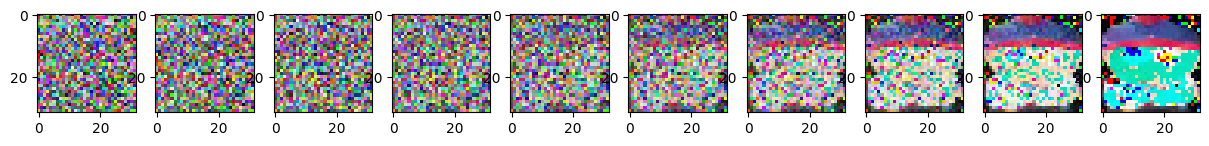

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.83it/s]


Epoch 71 | Train Loss: 811.3591982270972


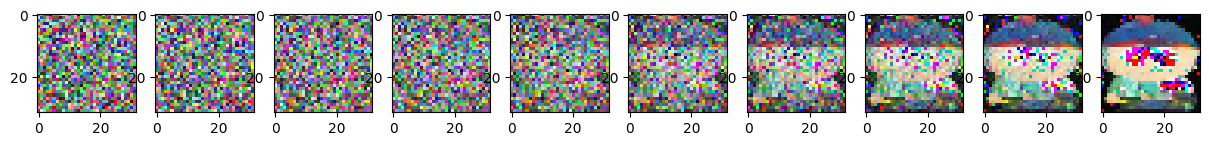

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.36it/s]


Epoch 72 | Train Loss: 814.8661818346441


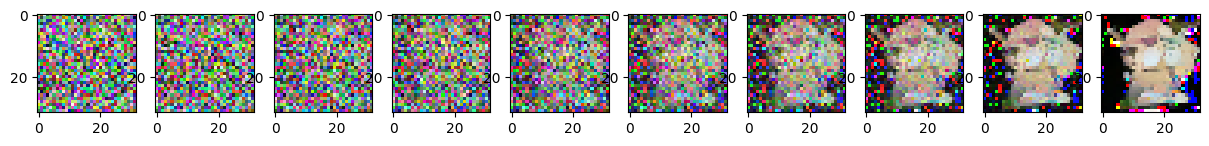

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.27it/s]


Epoch 73 | Train Loss: 808.5876621136865


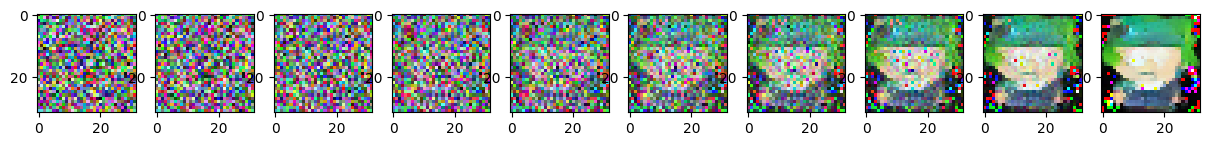

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.73it/s]


Epoch 74 | Train Loss: 837.0136535509796


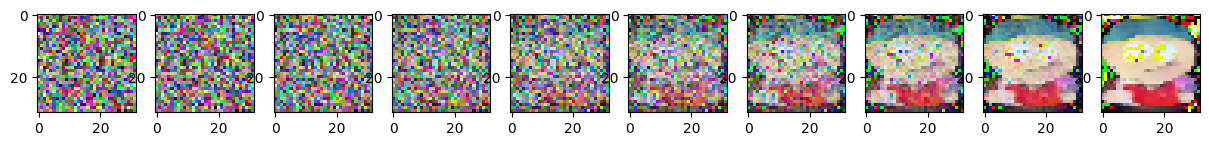

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.02it/s]


Epoch 75 | Train Loss: 798.0824570140038


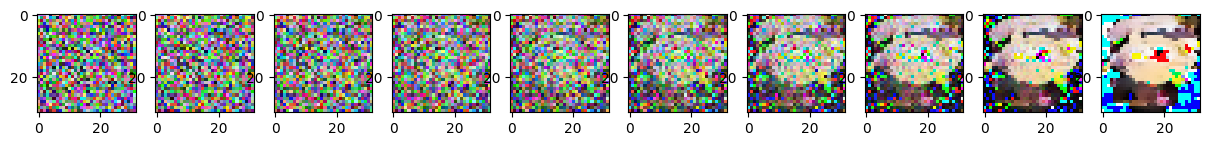

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.64it/s]


Epoch 76 | Train Loss: 823.8216210506347


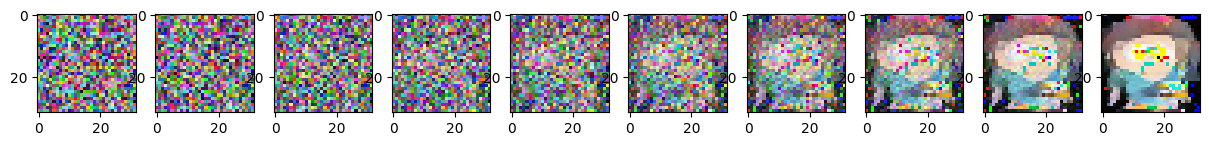

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.72it/s]


Epoch 77 | Train Loss: 791.779405741239


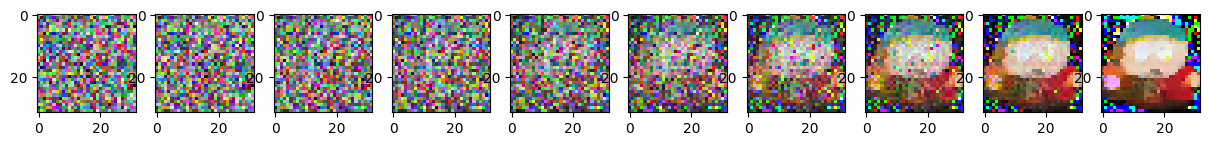

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.87it/s]


Epoch 78 | Train Loss: 799.6606725562224


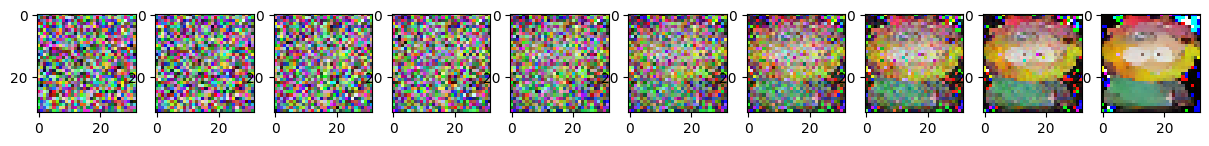

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.00it/s]


Epoch 79 | Train Loss: 803.6149810723648


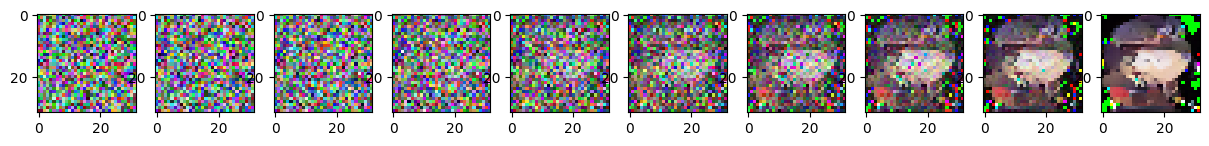

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.77it/s]


Epoch 80 | Train Loss: 816.7432901748758


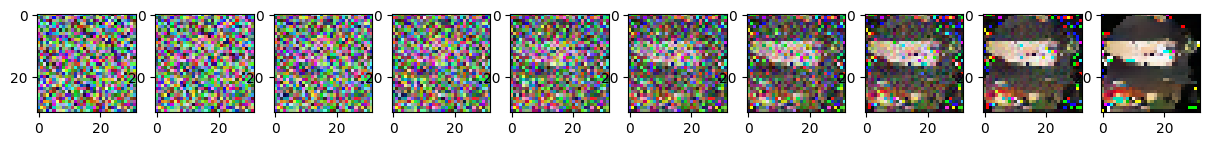

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.16it/s]


Epoch 81 | Train Loss: 787.6770800996827


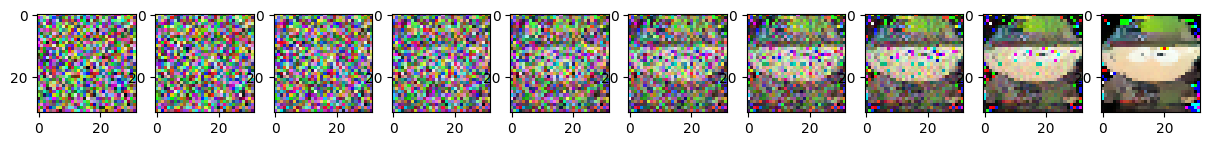

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.98it/s]


Epoch 82 | Train Loss: 786.9119121223096


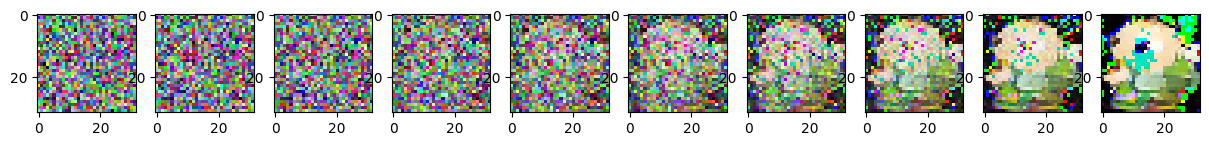

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.18it/s]


Epoch 83 | Train Loss: 798.6869287217163


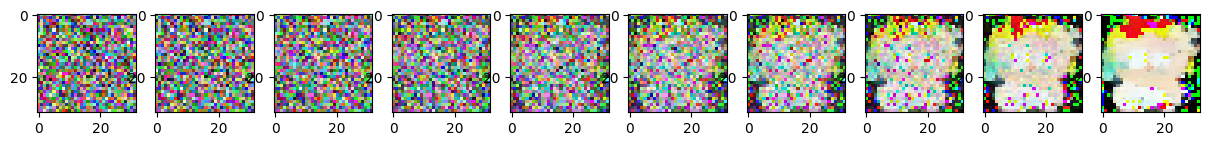

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.93it/s]


Epoch 84 | Train Loss: 805.0359937655215


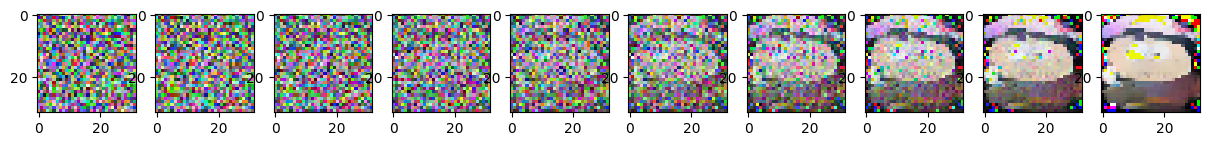

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.53it/s]


Epoch 85 | Train Loss: 805.1658399299807


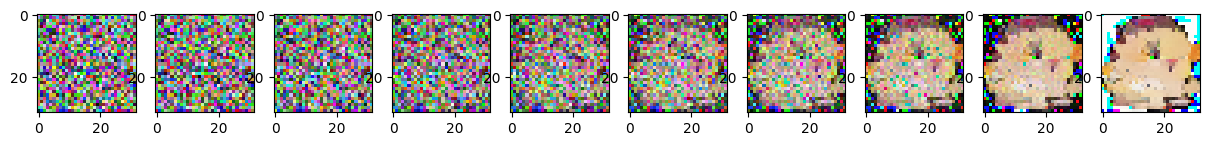

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.33it/s]


Epoch 86 | Train Loss: 771.9412521126518


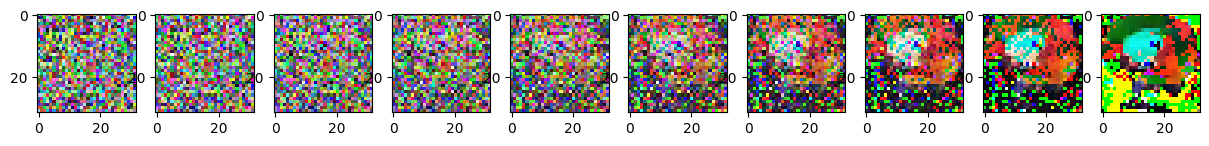

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.26it/s]


Epoch 87 | Train Loss: 784.0011781267247


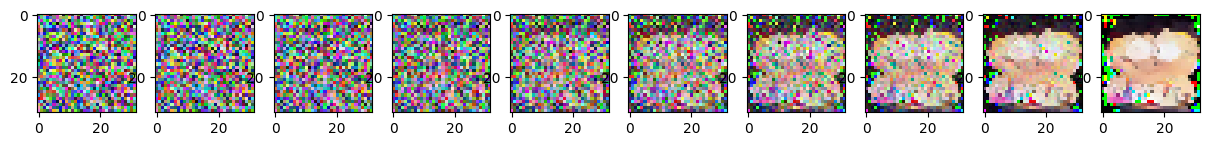

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.18it/s]


Epoch 88 | Train Loss: 802.7562280111755


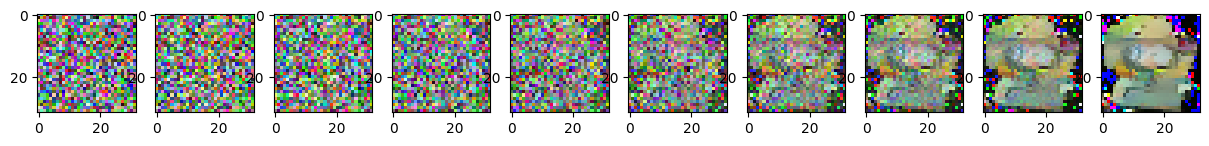

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 14.98it/s]


Epoch 89 | Train Loss: 803.4318357219233


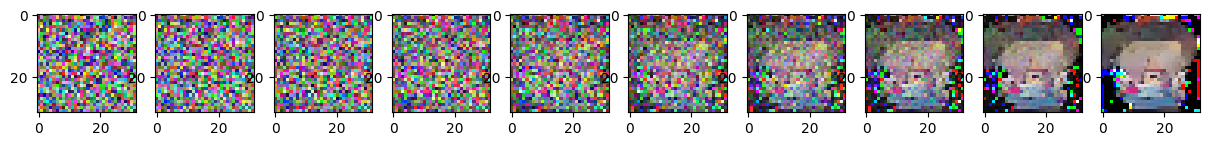

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.24it/s]


Epoch 90 | Train Loss: 796.5341042356512


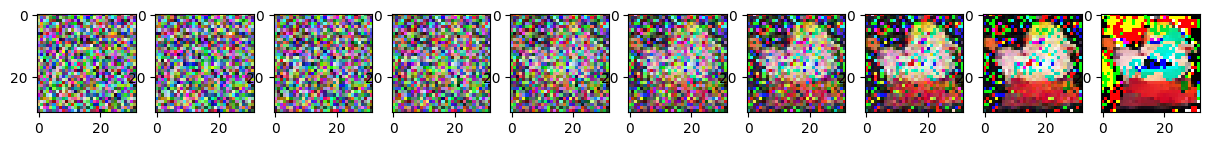

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.21it/s]


Epoch 91 | Train Loss: 764.0714108633416


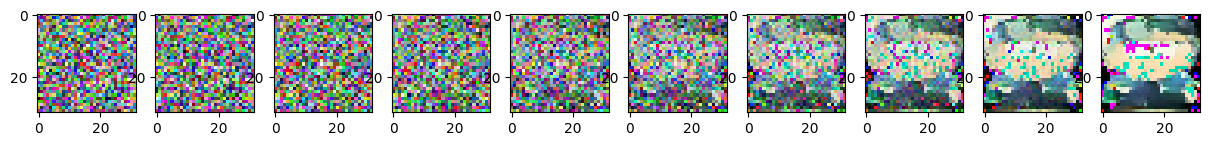

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 14.41it/s]


Epoch 92 | Train Loss: 787.2750543253311


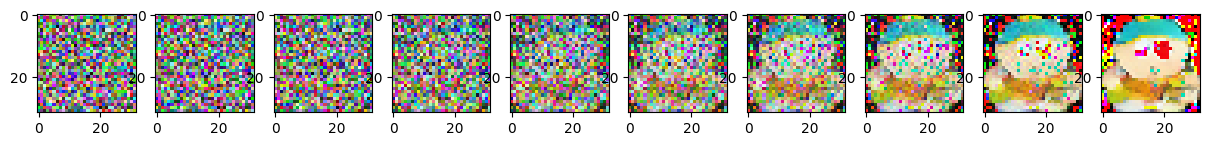

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 14.42it/s]


Epoch 93 | Train Loss: 786.2243140349062


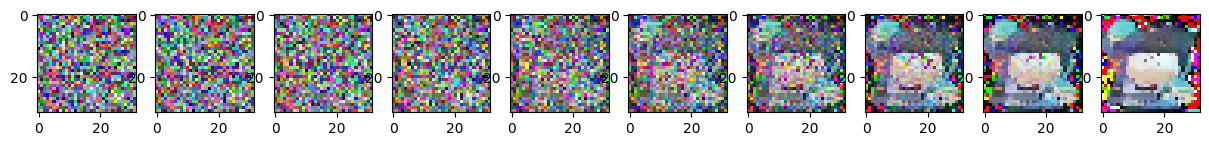

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.71it/s]


Epoch 94 | Train Loss: 804.5111194467439


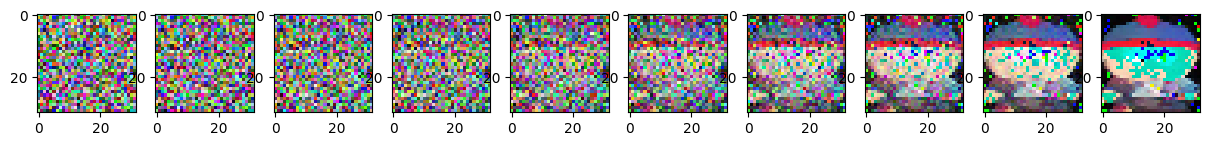

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.84it/s]


Epoch 95 | Train Loss: 779.3838903835541


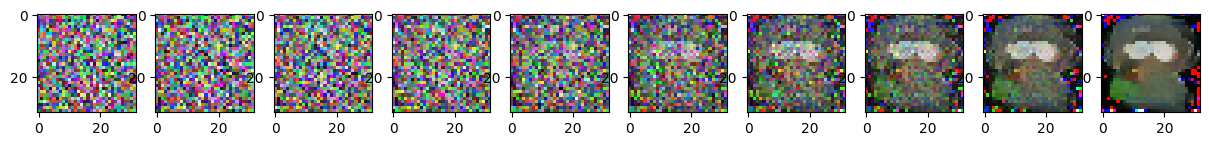

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.90it/s]


Epoch 96 | Train Loss: 805.8046853442329


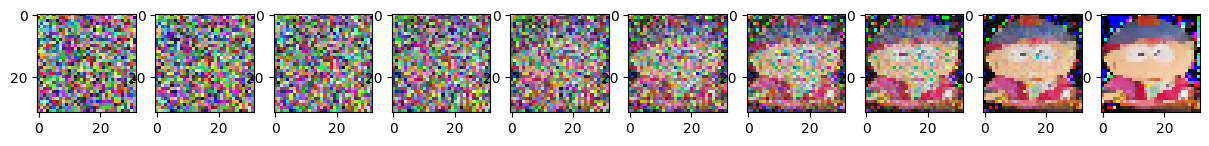

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.07it/s]


Epoch 97 | Train Loss: 793.6390264986893


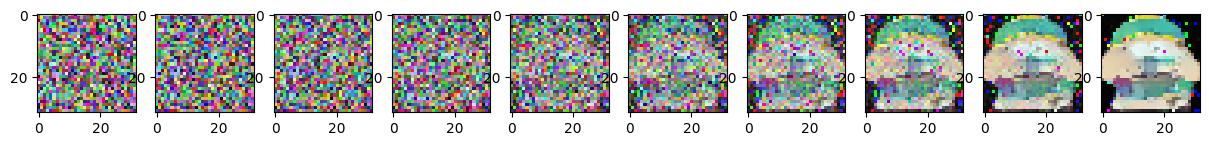

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.41it/s]


Epoch 98 | Train Loss: 765.5290618963852


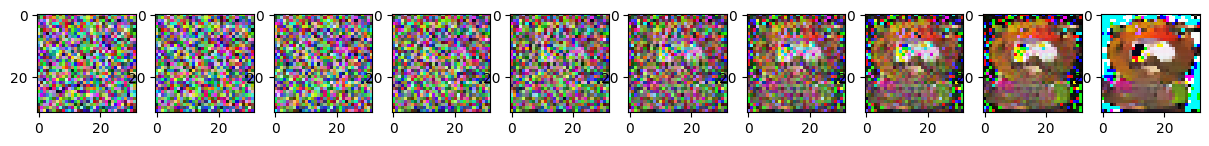

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.54it/s]


Epoch 99 | Train Loss: 800.5944958954194


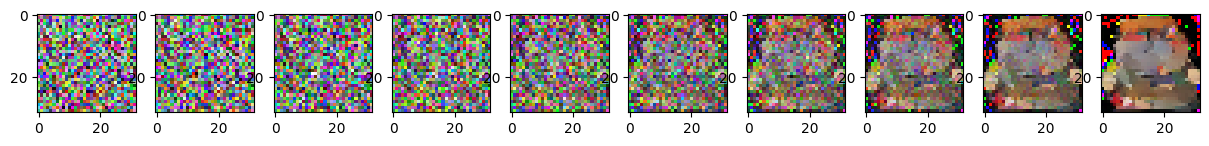

In [13]:
from torch.optim import Adam
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 100 # Try more!

for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, device)
    # eval_loss = eval_epoch(model, test_dataloader, device)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss}")
        
        euler_integration(model, torch.tensor(np.random.normal(size=[3, 32, 32]), dtype=torch.float32).to(device).unsqueeze(0))